<a href="https://colab.research.google.com/github/Ugadot/Tubable-Survivabilty-Off-chain/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np   
import networkx as nx
from scipy.optimize import fsolve
import math
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline
DEBUG=False

In [ ]:
# TODO: is this needed?

channel_to_demand_dict = {}
demand_to_channel_dict = {}


def Hfunc(graph, channel):
    return channel_to_demand_dict[channel]

def reverseHfunc(graph, demand):
    return demand_to_channel_dict[demand]

In [ ]:
def realErf(x):
  return 0.5 * math.erf(x) + 0.5
  # return math.erf(x)

def toMinimize(x, M, S, S_0):
  rightArg = (x - M) / S
  leftArg = (-x-M) / S
  # return np.abs(realErf(rightArg) - realErf(leftArg) - S_0)
  return realErf(rightArg) - realErf(leftArg) - S_0

In [ ]:
def blackbox(Mu, Sigma, S_0):
  '''
    given an Gaussian distribution with Mu and Sigma,
    calc the symmetric threshold x > 0 that ensures that
    the area beneath the graph between [-x,x] is larger or equal to S_0
  '''

  # TODO: Apply optimization function with T iterations that calc the needed x val
  new_capacity = fsolve(toMinimize, [np.abs(Mu)], args=(Mu, Sigma, S_0))
  # print (toMinimize(new_capacity, Mu, Sigma, S_0))
  return new_capacity

In [ ]:
# Sanity check for black box 
# demand average diff
mu = 0
# demand std
std = 1
# required survivability
sur = 0.9
capacity = blackbox(mu, std, sur)
print(capacity)
toMinimize(capacity, mu, std, sur)


[1.16308715]


-2.275957200481571e-14

In [ ]:
def findMinWcVal(graph, channel, S_0, demand_channel):
    '''  
        Inputs:
          The current graph
          An existing channel
          A new demand that should use this channel
          survivability demand

        returns the minimal capacity that should be added to the channel,
        in order to maintain the required survivability
    '''
    source, target, mu, sigma = demand_channel
    M, S = mu, sigma
    prev_capacity = 0
    u,v = channel
    
    if DEBUG: print("s: {}, t: {}, has_edge {}".format(u, v, graph.has_edge(u,v)))
    if graph.has_edge(u,v):        
        if DEBUG: print("edge: {} demands: {}".format((u,v), graph[u][v]['demands']))
        
        for demand in graph[u][v]['demands']:
            M += demand[2]
            S += demand[3]
            prev_capacity = graph[u][v]['weight']

    # TODO
    x = blackbox(M, S, S_0)
    delta = max(0, x - prev_capacity) # TODO: We can use negative weights to give better חסם
    if DEBUG:
      print("[findMinWcVal] channel: {} demand: {} ".format(channel, demand_channel))
      print("[findMinWcVal] input graph {}".format(graph.edges.data()))
      print("[findMinWcVal] M: {} S: {}".format(M,S))
      print("[findMinWcVal] prev_capacity: {}".format(prev_capacity))
      print("[findMinWcVal] new_capacity: {}".format(x))
      print("[findMinWcVal] delta: {}".format(delta))
      
    return delta, delta

    return 0

In [ ]:
def add_demand(currentGraph, newDemand, S_0):
    '''
        Perform a single iteration of the Algorithm:
        Inputs:
          current graph
          a new demand
          required survivability per edge

        - find all the existing possible paths
        - calculate the required additional deposit on each path to maintain survivability
        - choose the miniaml path. can create a new direct path if optimal.
    '''
    print("newDemand:")
    print(newDemand)
    source, target, mu, sigma = newDemand
    oposite_demand = (target, source, -mu, sigma)
    resGraph = nx.DiGraph()
    resGraph.add_nodes = currentGraph.nodes()
    
    # calc all possible costs of new demand 

    for path in nx.all_simple_paths(currentGraph, source=source, target=target):
        # print("path: ", path)
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            if (u,v) not in resGraph.edges():
                # cost = findMinWcVal(currentGraph, (u,v), S_0, newDemand)
                c_uv, c_vu = findMinWcVal(currentGraph, (u,v), S_0, newDemand)
                resGraph.add_edge(u,v, weight=c_uv+c_vu, c_uv=c_uv, c_vu=c_vu)

    # add direct path
    c_uv, c_vu = findMinWcVal(currentGraph, (source, target), S_0, newDemand)
    resGraph.add_edge(source, target, weight=c_uv+c_vu, c_uv=c_uv, c_vu=c_vu)
    if DEBUG:
        print("resGraph:")
        print(resGraph.edges.data())

    # find shortest path
    s_path = nx.shortest_path(resGraph, source, target, 
                                            weight='weight', method='dijkstra')
    print("shortest path: ")
    print(s_path)

    # update weights in deposit graph
    for i in range(len(s_path) - 1):
        u = s_path[i]
        v = s_path[i + 1]

        if currentGraph.has_edge(u,v):
            # update deposit        
            currentGraph[u][v]['weight'] += resGraph[u][v]['c_uv']
            currentGraph[v][u]['weight'] += resGraph[u][v]['c_vu']
            # update flows
            currentGraph[u][v]['demands'].append(newDemand)
            # update also in the oposite edge

            currentGraph[v][u]['demands'].append(oposite_demand)
        else:
          assert u == source and v == target
          # update deposit        
          currentGraph.add_edge(u,v, weight=resGraph[u][v]['c_uv'])
          currentGraph.add_edge(v,u, weight=resGraph[u][v]['c_vu'])
          # update flows
          currentGraph[u][v]['demands'] = [newDemand]
          currentGraph[v][u]['demands'] = [oposite_demand]


    return currentGraph  
    


In [ ]:
def getAlgoRes(demand_list, orig_graph, S_0):
  current_graph = orig_graph
  for index, demand in enumerate(demand_list):
    print ("\n################## iter {} ###################\n".format(index))
    current_graph = add_demand(current_graph, demand, S_0)
    printGraph(current_graph)
  return current_graph

In [ ]:
def printGraph(graph):
  seed = 13
  draw_options = {
  "font_size": 18,
  "node_size": 1500,
  "node_color": "white",
  "edgecolors": "black",
  "linewidths": 3,
  "width": 3,
  }
  fig, ax = plt.subplots(figsize=(5,5))
  ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
  pos = nx.shell_layout(graph)
  
  # print("Nodes position: {}".format(pos))
  labels = nx.get_edge_attributes(graph,'weight')
  # print(graph.edges.data())
  nx.draw_networkx(graph, pos=pos, **draw_options, ax=ax)
  nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels, label_pos = 0.5, ax=ax, alpha=0.5)

  plt.show()

# def printGraph(graph):    
#   draw_options = {
#   "font_size": 18,
#   "node_size": 1500,
#   "node_color": "white",
#   "edgecolors": "black",
#   "linewidths": 3,
#   "width": 3,
#   }
#   plt.figure()
#   pos = {0: (0,0), 1: (1,2), 2: (2,3)}
#   labels = nx.get_edge_attributes(graph,'weight')
#   pos=nx.spring_layout(graph)
#   #print(graph)
#   print(graph.edges.data())
#   nx.draw_networkx(graph, pos=pos, **draw_options)
#   nx.draw_networkx_edge_labels(graph, pos=nx.spring_layout(graph), edge_labels=labels, label_pos = 0.5)

In [ ]:
print("Dummy Example:")
N = 3
S_0 = 0.9
demand_list = []
demand_list.append((0, 1, 10, 1))
demand_list.append((0, 2, -10, 1))
demand_list.append((2, 1, -2, 0.5))
print(demand_list)

Dummy Example:


**Simple Solution:**
For each demand, We will add a direct path between the clients, which will satisfy the survivability constraint.

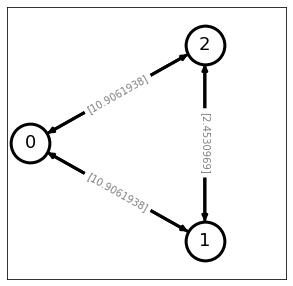

In [ ]:
# Direct graph
def direct_path_solution(demand_list, N):
  graph = nx.DiGraph()
  graph.add_nodes_from(range(N))
  for index, demand in enumerate(demand_list):
    u, v, mu, sigma = demand
    oposite_demand = (v, u, -mu, sigma)
    c_uv, c_vu = findMinWcVal(graph, (u, v), S_0, demand)
    graph.add_edge(u,v, weight=c_uv)
    graph.add_edge(v,u, weight=c_vu)
    # update flows
    graph[u][v]['demands'] = [demand]
    graph[v][u]['demands'] = [oposite_demand]

  printGraph(graph)

direct_path_solution(demand_list, 3)
    

In [ ]:
# 
graph = nx.DiGraph()
graph.add_nodes_from(range(N))
#nx.draw_networkx(graph)
final_graph = getAlgoRes(demand_list, graph, S_0)
#nx.draw_networkx_edge_lables(final_graph , **draw_options)


In the above example, we can see that there is signifcant difference in the demands between 2 to 0 and 0 to 1.
Therefore it is better to satisfy the demand from 1 to 2 via this path, instead of opening a new channel.

In [ ]:
printGraph(final_graph)